# Microvilli orientation
- Visualize Anastasia's microvilli orientation data (more detailed excel sent in Aug 2020)
- Determine if microvilli twist is more or less constant in the DRA
- Determine if candidates for polarization detection have more or less orthogonally oriented microvilli in the DRA

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

from vis.hex_lattice import hexplot
from vis.fig_tools import linear_cmap

In [2]:
xl_dir = '~/Data/200824_microvilli.xlsx'
full_df = pd.read_excel(xl_dir, sheet_name='microvilli angle', header=None, index_col=None)
#display(full_df)

In [3]:
# The excel file contains a table for each ommatidium, the formatting is very consistent
twist = []
# TODO: extract other data
om_df = []
cell_df = []

for i in range(0, 29):  # ommatidia
    # excel has 16 rows for each ommatidia, but only 13 have data
    this_range = full_df.loc[i * 16: i * 16 + 13].reset_index(drop=True)
    this_om = this_range.iloc[0, 0]
    if this_om == 'C5':  # C5 has an extra row that replaces one of the blank ones at the end
        this_range = full_df.loc[i * 16: i * 16 + 14].reset_index(drop=True)
        rows = 11
    else:
        rows = 10
    # these cells contain the z-index each measurement was taken
    z_st_cols = this_range.iloc[3, 13:]  

    assert(len(this_om) == 2)  # check om name
    assert(len(z_st_cols) == 9)  # check that there are 9 photoreceptors
    
    for ii, this_st in this_range.iloc[0, 4:13].items():  # subtypes 
        if '(' in this_st:  # some have the old subtype nomenclature in ()
            this_st = this_st.split('(')[0]
        this_st = this_st.strip().upper()
        # Should R7' be changed to R7p? 
        z_col = z_st_cols[z_st_cols == this_st.lower()].index[0]
        
        # Add negative sign to indices of stacks that start proximal so the direction is distal->proximal
        if this_range.iloc[2, 4] < this_range.iloc[3, 4]: # start/end index for R1
            z_inds = this_range.iloc[4:, z_col]
        else:
            z_inds = this_range.iloc[4:, z_col] * -1.0
        
        twist.append(pd.DataFrame({'om': [this_om]*rows, 
                                     'subtype': [this_st]*rows, 
                                     'z-index': z_inds, 
                                     'angle': this_range.iloc[4:, ii]}))
        
twist_df = pd.concat(twist, ignore_index=True)
twist_df = twist_df.astype({'z-index': float, # because there are NaNs
                           'angle': float})
#display((twist_df.loc[1900, 'z-index']))

In [4]:
all_om = sorted(twist_df['om'].unique())
dra_om = ['A4', 'A5', 'B5', 'B6', 'C5', 'C6', 'D6', 'D7', 'E6', 'E7']  # as defined by connectivity clustering
ndra_om = [str(o) for o in all_om if o not in dra_om]
subtypes = sorted(twist_df['subtype'].unique())

## Compute angular differences between measurements
- Data is collected on ImageJ, which records the smaller (< 180) angle between two lines drawn by the user
- Anastasia added a negative sign to angles measured clockwise from the reference angle
- Because of this, we cannot use angle1 - angle2 as the difference
- First, the angle1 - angle2 differences are converted into minimal positive (counter-clockwise) angles by taking % 360 , "_diff"
- Secondly, for counter clockwise angles more than +180, we take the smaller angle in the CCW direction by subtracting 360, "diff". This retains the sign convention of negative -> CW twist 

In [5]:


for i, om_rows in twist_df.groupby('om'):
    for ii, rows in om_rows.groupby('subtype'):
        n = 0
        for iii, row in rows.sort_values('z-index').iterrows():
            twist_df.loc[iii, 'n'] = int(n)
            if n == 0:  # first measurement has diff of 0
                twist_df.loc[iii, '_diff'] = np.nan
                twist_df.loc[iii, 'diff'] = np.nan
                twist_df.loc[iii, 'cumulative'] = 0.0
                twist_df.loc[iii, '_angle'] = twist_df.loc[iii, 'angle']
                twist_df.loc[iii, 'interval_len'] = np.nan # 0.0
                twist_df.loc[iii, 'interval_z'] = np.nan
                previous = (iii, twist_df.loc[iii, 'angle'])
            elif math.isnan(twist_df.loc[iii, 'angle']):
                #print(f"NaN found for {i}_{ii} measurement: {n}")
                twist_df.loc[iii, '_diff'] = np.nan
                twist_df.loc[iii, 'diff'] = np.nan
                twist_df.loc[iii, 'cumulative'] = np.nan
                twist_df.loc[iii, '_angle'] = np.nan
                twist_df.loc[iii, 'interval_len'] = np.nan
                twist_df.loc[iii, 'interval_z'] = np.nan
                # previous = measurement before the NaN, though n still increases by 1
            else:
                twist_df.loc[iii, '_diff'] = (twist_df.loc[iii, 'angle'] - previous[1]) % 360.0
                twist_df.loc[iii, 'diff'] = twist_df.loc[iii, '_diff'] - 360.0 * (twist_df.loc[iii, '_diff'] > 180.0)
                twist_df.loc[iii, 'cumulative'] = twist_df.loc[previous[0], 'cumulative'] + twist_df.loc[iii, 'diff']
                twist_df.loc[iii, '_angle'] = twist_df.loc[previous[0], '_angle'] + twist_df.loc[iii, 'diff']
                twist_df.loc[iii, 'interval_len'] = (twist_df.loc[iii, 'z-index'] - twist_df.loc[previous[0], 'z-index']) * 8.0 / 1000.0
                twist_df.loc[iii, 'interval_z'] = twist_df.loc[iii, 'z-index'] - twist_df.loc[previous[0], 'z-index']
                # because 1 px = 8/1000 microns
                previous = (iii, twist_df.loc[iii, 'angle'])
            n += 1
twist_df['diff_per_micron'] = twist_df['diff'] / twist_df['interval_len']
#twist_df['_angle'] = twist_df['_angle'] % 180.0
            
#twist_df['diff'] = twist_df['_diff'] - 360*(twist_df['_diff']>180)

# display(twist_df.loc[(twist_df['om']=='A0') & (twist_df['subtype'] == 'R5'), 
#                     ('om', 'subtype', 'z-index', 'angle', '_diff', 'diff', 'cumulative')].sort_values('z-index'))

# Example D6_R1 shows how NaNs are used
display(twist_df.loc[(twist_df['om']=='D6') & (twist_df['subtype'] == 'R1'), :].sort_values('z-index'))
display(twist_df.loc[(twist_df['om']=='A4') & (twist_df['subtype'] == 'R8'), :].sort_values('z-index'))
display(twist_df.loc[(twist_df['om']=='B1') & (twist_df['subtype'] == 'R7'), :].sort_values('z-index'))

display(twist_df.loc[:, 'cumulative'].max())
display(twist_df.loc[:, 'diff'].max())

,om,subtype,z-index,angle,n,_diff,diff,cumulative,_angle,interval_len,interval_z,diff_per_micron
1530,D6,R1,827.0,-95.8,0.0,NaN,NaN,0.0,-95.8,NaN,NaN,NaN
1531,D6,R1,920.0,-106.2,1.0,349.6,-10.4,-10.4,-106.2,0.744,93.0,-13.978495
1532,D6,R1,1013.0,-99.2,2.0,7.0,7.0,-3.4,-99.2,0.744,93.0,9.408602
1533,D6,R1,1106.0,-89.2,3.0,10.0,10.0,6.6,-89.2,0.744,93.0,13.440860
1534,D6,R1,1199.0,-92.3,4.0,356.9,-3.1,3.5,-92.3,0.744,93.0,-4.166667
1535,D6,R1,1292.0,-94.2,5.0,358.1,-1.9,1.6,-94.2,0.744,93.0,-2.553763
1536,D6,R1,1385.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1537,D6,R1,1478.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1538,D6,R1,1571.0,-114.9,8.0,339.3,-20.7,-19.1,-114.9,2.232,279.0,-9.274194
1539,D6,R1,1661.0,-114.9,9.0,0.0,0.0,-19.1,-114.9,0.720,90.0,0.000000


,om,subtype,z-index,angle,n,_diff,diff,cumulative,_angle,interval_len,interval_z,diff_per_micron
2519,A4,R8,-1134.0,-25.0,0.0,NaN,NaN,0.0,-25.0,NaN,NaN,NaN
2520,A4,R8,-1094.0,46.0,1.0,71.0,71.0,71.0,46.0,0.32,40.0,221.8750
2521,A4,R8,-1054.0,-67.4,2.0,246.6,-113.4,-42.4,-67.4,0.32,40.0,-354.3750
2522,A4,R8,-1014.0,-63.0,3.0,4.4,4.4,-38.0,-63.0,0.32,40.0,13.7500
2523,A4,R8,-974.0,-57.8,4.0,5.2,5.2,-32.8,-57.8,0.32,40.0,16.2500
2524,A4,R8,-934.0,-61.3,5.0,356.5,-3.5,-36.3,-61.3,0.32,40.0,-10.9375
2525,A4,R8,-894.0,-58.4,6.0,2.9,2.9,-33.4,-58.4,0.32,40.0,9.0625
2526,A4,R8,-854.0,-53.1,7.0,5.3,5.3,-28.1,-53.1,0.32,40.0,16.5625
2527,A4,R8,-814.0,-50.2,8.0,2.9,2.9,-25.2,-50.2,0.32,40.0,9.0625
2528,A4,R8,-774.0,-49.7,9.0,0.5,0.5,-24.7,-49.7,0.32,40.0,1.5625


,om,subtype,z-index,angle,n,_diff,diff,cumulative,_angle,interval_len,interval_z,diff_per_micron
2329,B1,R7,-3168.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN
2330,B1,R7,-3091.0,-7.3,1.0,352.7,-7.3,-7.3,-7.3,0.616,77.0,-11.850649
2331,B1,R7,-3014.0,-3.6,2.0,3.7,3.7,-3.6,-3.6,0.616,77.0,6.006494
2332,B1,R7,-2937.0,-81.4,3.0,282.2,-77.8,-81.4,-81.4,0.616,77.0,-126.298701
2333,B1,R7,-2860.0,-77.5,4.0,3.9,3.9,-77.5,-77.5,0.616,77.0,6.331169
2334,B1,R7,-2783.0,-77.5,5.0,0.0,0.0,-77.5,-77.5,0.616,77.0,0.000000
2335,B1,R7,-2706.0,-72.6,6.0,4.9,4.9,-72.6,-72.6,0.616,77.0,7.954545
2336,B1,R7,-2629.0,9.3,7.0,81.9,81.9,9.3,9.3,0.616,77.0,132.954545
2337,B1,R7,-2552.0,-66.3,8.0,284.4,-75.6,-66.3,-66.3,0.616,77.0,-122.727273
2338,B1,R7,-2476.0,-64.1,9.0,2.2,2.2,-64.1,-64.1,0.608,76.0,3.618421


133.1

127.29999999999998

## 

In [6]:
#twist_df['cosine'] = np.cos(twist_df['angle']*(np.pi/180.0))
twist_df['cosine_sq'] = np.cos(twist_df['angle']*(np.pi/180.0)) ** 2
twist_df['CCW_angle'] = [(360.0 + x) if x < 0 else x for x in twist_df['angle']]

In [7]:
# fig, ax = plt.subplots(15, 2, figsize=[25, 80], sharey=True)
# axes = ax.flatten()
# i = 0
# for om, rows in twist_df.groupby('om'):
    
#     #display(rows)
#     sns.lineplot(x='z-index', y='cosine_sq', hue='subtype', data=rows, markers=True, ax=axes[i])
#     axes[i].set_title(f"Ommatidium: {om}")
#     i += 1
    
# axes[-1].remove()
# #fig.savefig("/mnt/home/nchua/Dropbox/200902_microvilli_raw_all.pdf", bbox_inches='tight')

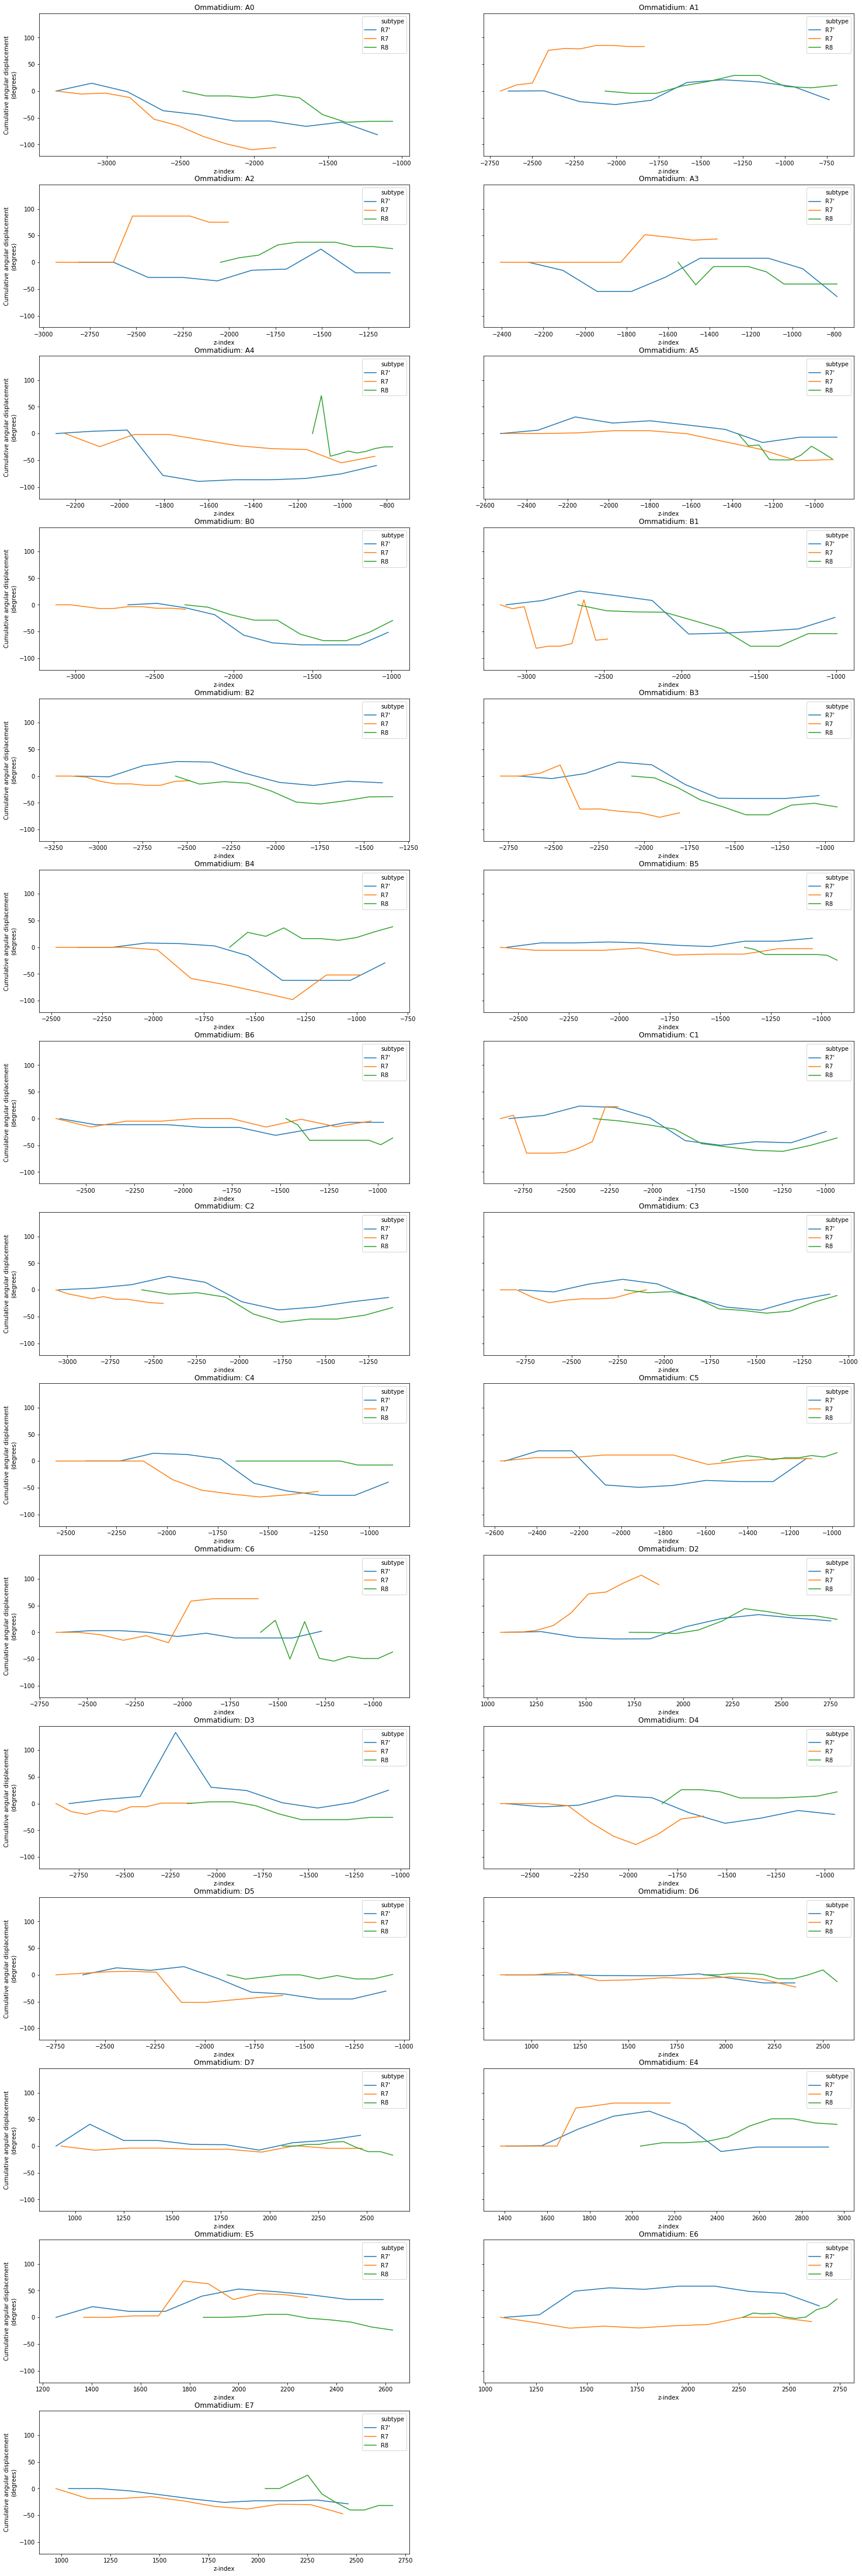

In [8]:
fig, ax = plt.subplots(15, 2, figsize=[25, 80], sharey=True)
axes = ax.flatten()
i = 0
for om, rows in twist_df.groupby('om'):
    rows = rows.loc[[i for i, v in rows['subtype'].items() if int(v[1]) > 6]] 
    #display(rows)
    sns.lineplot(x='z-index', y='cumulative', hue='subtype', data=rows, markers=True, ax=axes[i])
    axes[i].set_title(f"Ommatidium: {om}")
    axes[i].set_ylabel("Cumulative angular displacement\n(degrees)")
    i += 1
    
axes[-1].remove()
#fig.savefig("/mnt/home/nchua/Dropbox/200902_microvilli_raw_lvf.pdf", bbox_inches='tight')

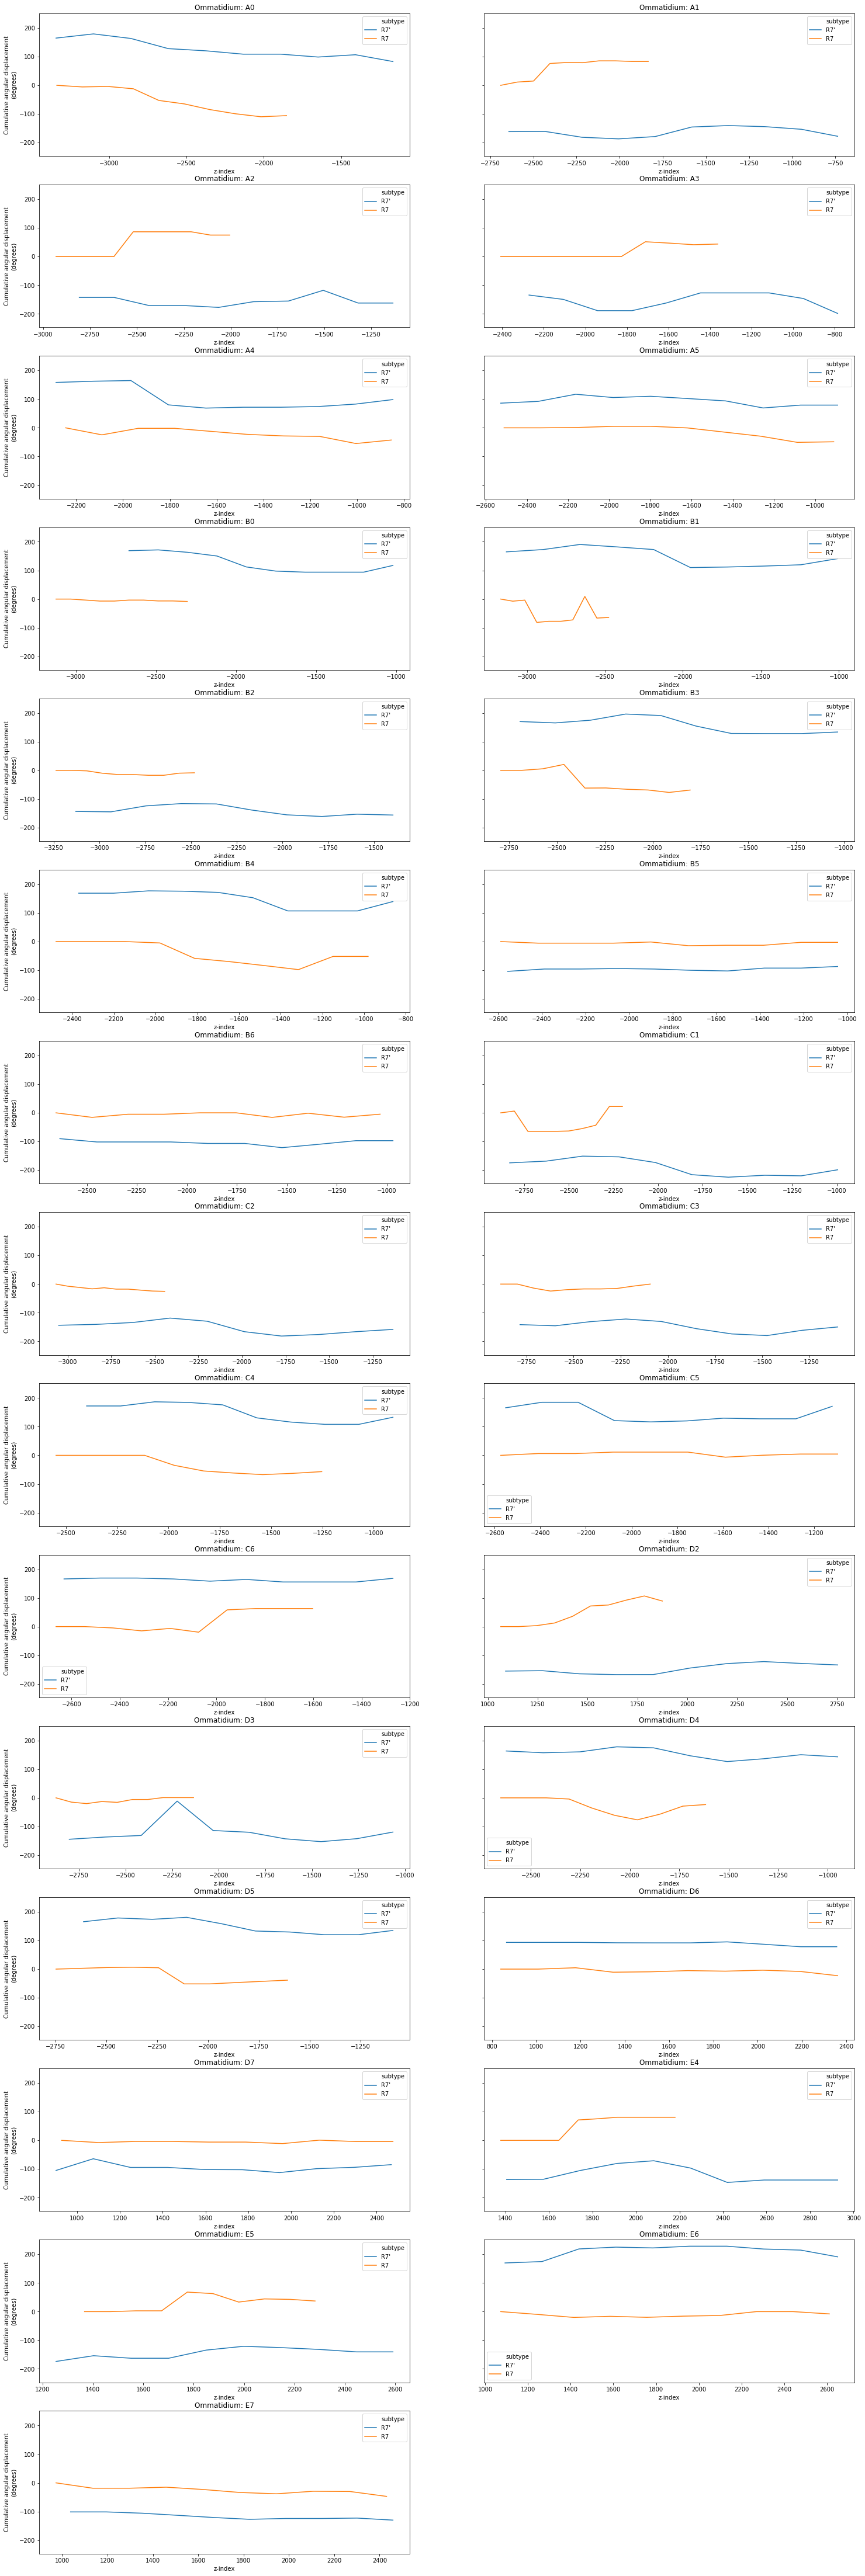

In [9]:
fig, ax = plt.subplots(15, 2, figsize=[25, 80], sharey=True)
axes = ax.flatten()
i = 0
for om, rows in twist_df.groupby('om'):
    rows = rows.loc[[i for i, v in rows['subtype'].items() if int(v[1]) == 7]] 
    #display(rows)
    sns.lineplot(x='z-index', y='_angle', hue='subtype', data=rows, markers=True, ax=axes[i])
    #sns.lineplot(x='z-index', y=)
    axes[i].set_title(f"Ommatidium: {om}")
    axes[i].set_ylabel("Cumulative angular displacement\n(degrees)")
    i += 1
    
axes[-1].remove()
#fig.savefig("/mnt/home/nchua/Dropbox/200902_microvilli_raw_lvf.pdf", bbox_inches='tight')

In [10]:
abs_diff = twist_df.copy()
#abs_diff['diff'] = np.abs(abs_diff['diff'])
abs_diff['abs_diff_per_micron'] = np.abs(abs_diff['diff_per_micron'])
abs_diff['previous_z'] = abs_diff['z-index'] - abs_diff['interval_z']

display(abs_diff['abs_diff_per_micron'].median())

5.2721088435374055

In [11]:
abs_diff.sort_values('abs_diff_per_micron', ascending=False).loc[abs_diff['subtype']=='R7', 
                    ['om', 'subtype','previous_z', 'z-index', 'diff', 'diff_per_micron']].head(20)

,om,subtype,previous_z,z-index,diff,diff_per_micron
2336,B1,R7,-2706.0,-2629.0,81.9,132.954545
2332,B1,R7,-3014.0,-2937.0,-77.8,-126.298701
2337,B1,R7,-2629.0,-2552.0,-75.6,-122.727273
2241,C1,R7,-2805.0,-2729.0,-70.9,-116.611842
2247,C1,R7,-2349.0,-2273.0,65.4,107.565789
165,A2,R7,-2623.0,-2520.0,86.5,104.975728
344,E4,R7,1646.0,1735.0,71.2,100.000000
1334,B3,R7,-2464.0,-2354.0,-82.5,-93.750000
1156,C6,R7,-2074.0,-1956.0,77.9,82.521186
2422,A1,R7,-2499.0,-2404.0,61.2,80.526316


In [12]:
abs_diff.sort_values('abs_diff_per_micron', ascending=False).loc[abs_diff['subtype']=="R7'", 
                    ['om', 'subtype','previous_z', 'z-index', 'diff', 'diff_per_micron']].head(20)

,om,subtype,previous_z,z-index,diff,diff_per_micron
1473,D3,R7',-2416.0,-2223.0,119.9,77.655440
1474,D3,R7',-2223.0,-2030.0,-102.6,-66.450777
2472,A4,R7',-1966.0,-1806.0,-84.8,-66.250000
1926,C5,R7',-2234.0,-2075.0,-63.9,-50.235849
210,A3,R7',-951.0,-786.0,-52.1,-39.469697
306,E4,R7',2251.0,2420.0,-50.1,-37.056213
1206,B4,R7',-1533.0,-1366.0,-46.0,-34.431138
1932,C5,R7',-1280.0,-1121.0,43.5,34.198113
34,C4,R7',-1736.0,-1570.0,-45.3,-34.111446
2294,B1,R7',-2188.0,-1952.0,-62.9,-33.315678


,om,subtype,z-index,angle,n,_diff,diff,cumulative,_angle,interval_len,interval_z,diff_per_micron,cosine_sq,CCW_angle
2521,A4,R8,-1054.0,-67.4,2.0,246.6,-113.4,-42.4,-67.4,0.32,40.0,-354.375,0.147683,292.6


Text(0,0.5,'Frequency observed')

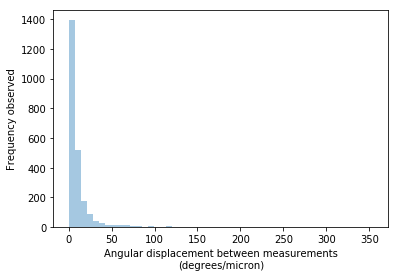

In [13]:
display(twist_df.loc[twist_df['diff_per_micron'].abs() == twist_df['diff_per_micron'].abs().max()])

fig, ax = plt.subplots(1)
ax = sns.distplot(twist_df['diff_per_micron'].abs().dropna(), kde=False)
ax.set_xlabel('Angular displacement between measurements\n(degrees/micron)')
ax.set_ylabel('Frequency observed')

In [14]:
# fig, ax = plt.subplots(15, 2, figsize=[25, 80], sharey=True)
# axes = ax.flatten()
# i = 0
# for om, rows in twist_df.groupby('om'):
#     rows = rows.loc[[i for i, v in rows['subtype'].items() if int(v[1]) < 7]] 
#     #display(rows)
#     sns.lineplot(x='z-index', y='cosine_sq', hue='subtype', data=rows, markers=True, ax=axes[i])
#     axes[i].set_title(f"Ommatidium: {om}")
#     i += 1
    
# axes[-1].remove()
# #fig.savefig("/mnt/home/nchua/Dropbox/200902_microvilli_raw_svf.pdf", bbox_inches='tight')

In [56]:
cols = pd.MultiIndex.from_product([['mean_diff', 'mean_diff_per_micron', 'SD_diff', 'mean_cosine_sq', 'r_mean_cosine_sq', 'SD_cosine_sq', 'max_displacement', 'SD_displacement', 'length', 'n_measure'], subtypes], names=['measure', 'subtype'])
twist_results = pd.DataFrame(columns = cols, index=all_om)

rh_length = pd.Series(index=all_om, dtype=float)

display(twist_df.loc[[bool([twist_df['om'] == 'A1']) & bool([twist_df['subtype'] == 'R7'])], 'cosine_sq'].mean())

for this_st, st_rows in twist_df.groupby('subtype'):
    for this_om, rows in st_rows.groupby('om'):
        # TODO: get rid of first difference when calculating mean? 
        
        #twist_results.loc[this_om, ('length', this_st)] = (rows['z-index'].max() - rows['z-index'].min()) * 8.0 /1000.0 # 1 px = 8/1000 microns
        
        twist_results.loc[this_om, ('mean_diff', this_st)] = rows['diff'].mean()
        twist_results.loc[this_om, ('SD_diff', this_st)] = rows['diff'].std()
        twist_results.loc[this_om, ('mean_diff_per_micron', this_st)] =  rows['diff_per_micron'].mean()
        
        twist_results.loc[this_om, ('mean_cosine_sq', this_st)] = rows['cosine_sq'].mean()
        
        twist_results.loc[this_om, ('SD_cosine_sq', this_st)] = rows['cosine_sq'].std()
        
        twist_results.loc[this_om, ('max_displacement', this_st)] = rows['cumulative'].max()
        twist_results.loc[this_om, ('SD_displacement', this_st)] = rows['cumulative'].std()
        #twist_results.loc[this_om, ('max_displacement_per_micron', this_st)] = rows['cumulative'].max() / twist_results.loc[this_om, ('length', this_st)]
        

#twist_results.loc[:, ('r_mean_cosine_sq')] = twist_results.loc[:, ('mean_cosine_sq', 'R7')] + 
#twist_results.loc[:, 'mean_cosine_sq']
#- twist_results.loc[:, ('mean_cosine_sq', 'R7')]
#display(twist_results.loc[:, ('mean_cosine_sq', 'R7')])
#display(twist_results.loc[:, ['mean_cosine_sq', 'r_mean_cosine_sq']])
# display(twist_results['length'])
# display(twist_results['mean_diff_per_micron'])

0.2606540710296966

measure mean_cosine_sq                                               \
subtype             R1         R2         R3          R4         R5   
A0            0.918955   0.718394   0.250798    0.893335   0.741273   
A1            0.903713   0.719712    0.29613    0.690571   0.352625   
A2            0.993766   0.768587   0.258918    0.851553   0.576765   
A3            0.971879   0.828762   0.281589    0.854627   0.504278   
A4            0.874632   0.109646   0.158864    0.897506   0.302756   
A5            0.995243  0.0560966  0.0325344    0.968693  0.0478263   
B0             0.90387   0.457855   0.136825    0.930235   0.756989   
B1            0.960076   0.450118  0.0951121    0.944914   0.682002   
B2            0.376643   0.173681   0.784345    0.389941   0.459853   
B3            0.880501   0.541913   0.518525    0.933681   0.583469   
B4            0.891602   0.614368   0.225364    0.750487   0.468734   
B5          0.00559298   0.962404   0.957923   0.0116179   0.963496   
B6            0.291616   0.843985    0.84866   0.0698122   0.967907   
C1            0.866757   0.612989   0.402246    0.677067   0.479053   
C2            0.386056   0.452065     0.8993    0.325533   0.411166   
C3            0.485047   0.641887   0.729555    0.364262   0.327773   
C4            0.773713   0.834533   0.038479    0.994148   0.719054   
C5            0.965391   0.233255   0.312687    0.861157   0.073995   
C6            0.168959   0.163069   0.131853    0.869653   0.246747   
D2            0.934487   0.847726   0.127765    0.925776   0.715114   
D3            0.144132  0.0975258   0.818054    0.425077    0.32264   
D4            0.928505   0.678223   0.365649    0.796904   0.588075   
D5             0.98958   0.825261    0.42241    0.913488    0.60928   
D6           0.0594153    0.97457   0.977908  0.00707258   0.978199   
D7            0.519027   0.942908   0.958128   0.0449764   0.973895   
E4            0.852453   0.919138   0.872332    0.785067   0.880184   
E5            0.932565   0.704947   0.339934    0.779483   0.251282   
E6            0.914172    0.43445   0.464498    0.546538   0.119752   
E7             0.57114   0.739945    0.76919    0.171616   0.747894   

measure                                            r_mean_cosine_sq            \
subtype         R6        R7        R7'         R8               R1        R2   
A0       0.0484928  0.470981   0.381149   0.809716         0.658301   0.45774   
A1       0.0166331   0.30606   0.850816   0.952426         0.643059  0.459058   
A2       0.0192615  0.414888   0.791043    0.76146         0.733112  0.507933   
A3         0.25525  0.793634   0.675536   0.830501         0.711225  0.568108   
A4        0.113918  0.803158   0.317026   0.363545         0.613978  0.848992   
A5        0.169533  0.851598  0.0647832   0.662196         0.734589  0.795442   
B0       0.0834359  0.991369   0.399895   0.521079         0.643216  0.197201   
B1       0.0461159  0.451163   0.615532   0.735772         0.699422  0.189464   
B2        0.950974    0.9613   0.593601   0.619698         0.115989  0.913027   
B3        0.132947  0.479477    0.72294   0.645569         0.619847  0.281259   
B4       0.0860193  0.518133   0.652843   0.454368         0.630948  0.353714   
B5        0.973474  0.980771  0.0176606  0.0181077         0.744939   0.70175   
B6        0.972929  0.976024  0.0706434  0.0712117        0.0309619  0.583331   
C1        0.412236  0.531323   0.778496   0.850886         0.606103  0.352335   
C2        0.878252  0.914644   0.710472   0.685914         0.125402  0.191411   
C3        0.924029  0.940712   0.687783   0.726351         0.224393  0.381233   
C4        0.203498  0.589522   0.621801   0.266706         0.513059  0.573879   
C5       0.0601228  0.983595   0.577285   0.994443         0.704737  0.972601   
C6        0.233201  0.670082   0.906603   0.785928         0.908305  0.902415   
D2       0.0334428  0.485173   0.667834    0.62862         0.673833  0.587072   
D3        0.9508

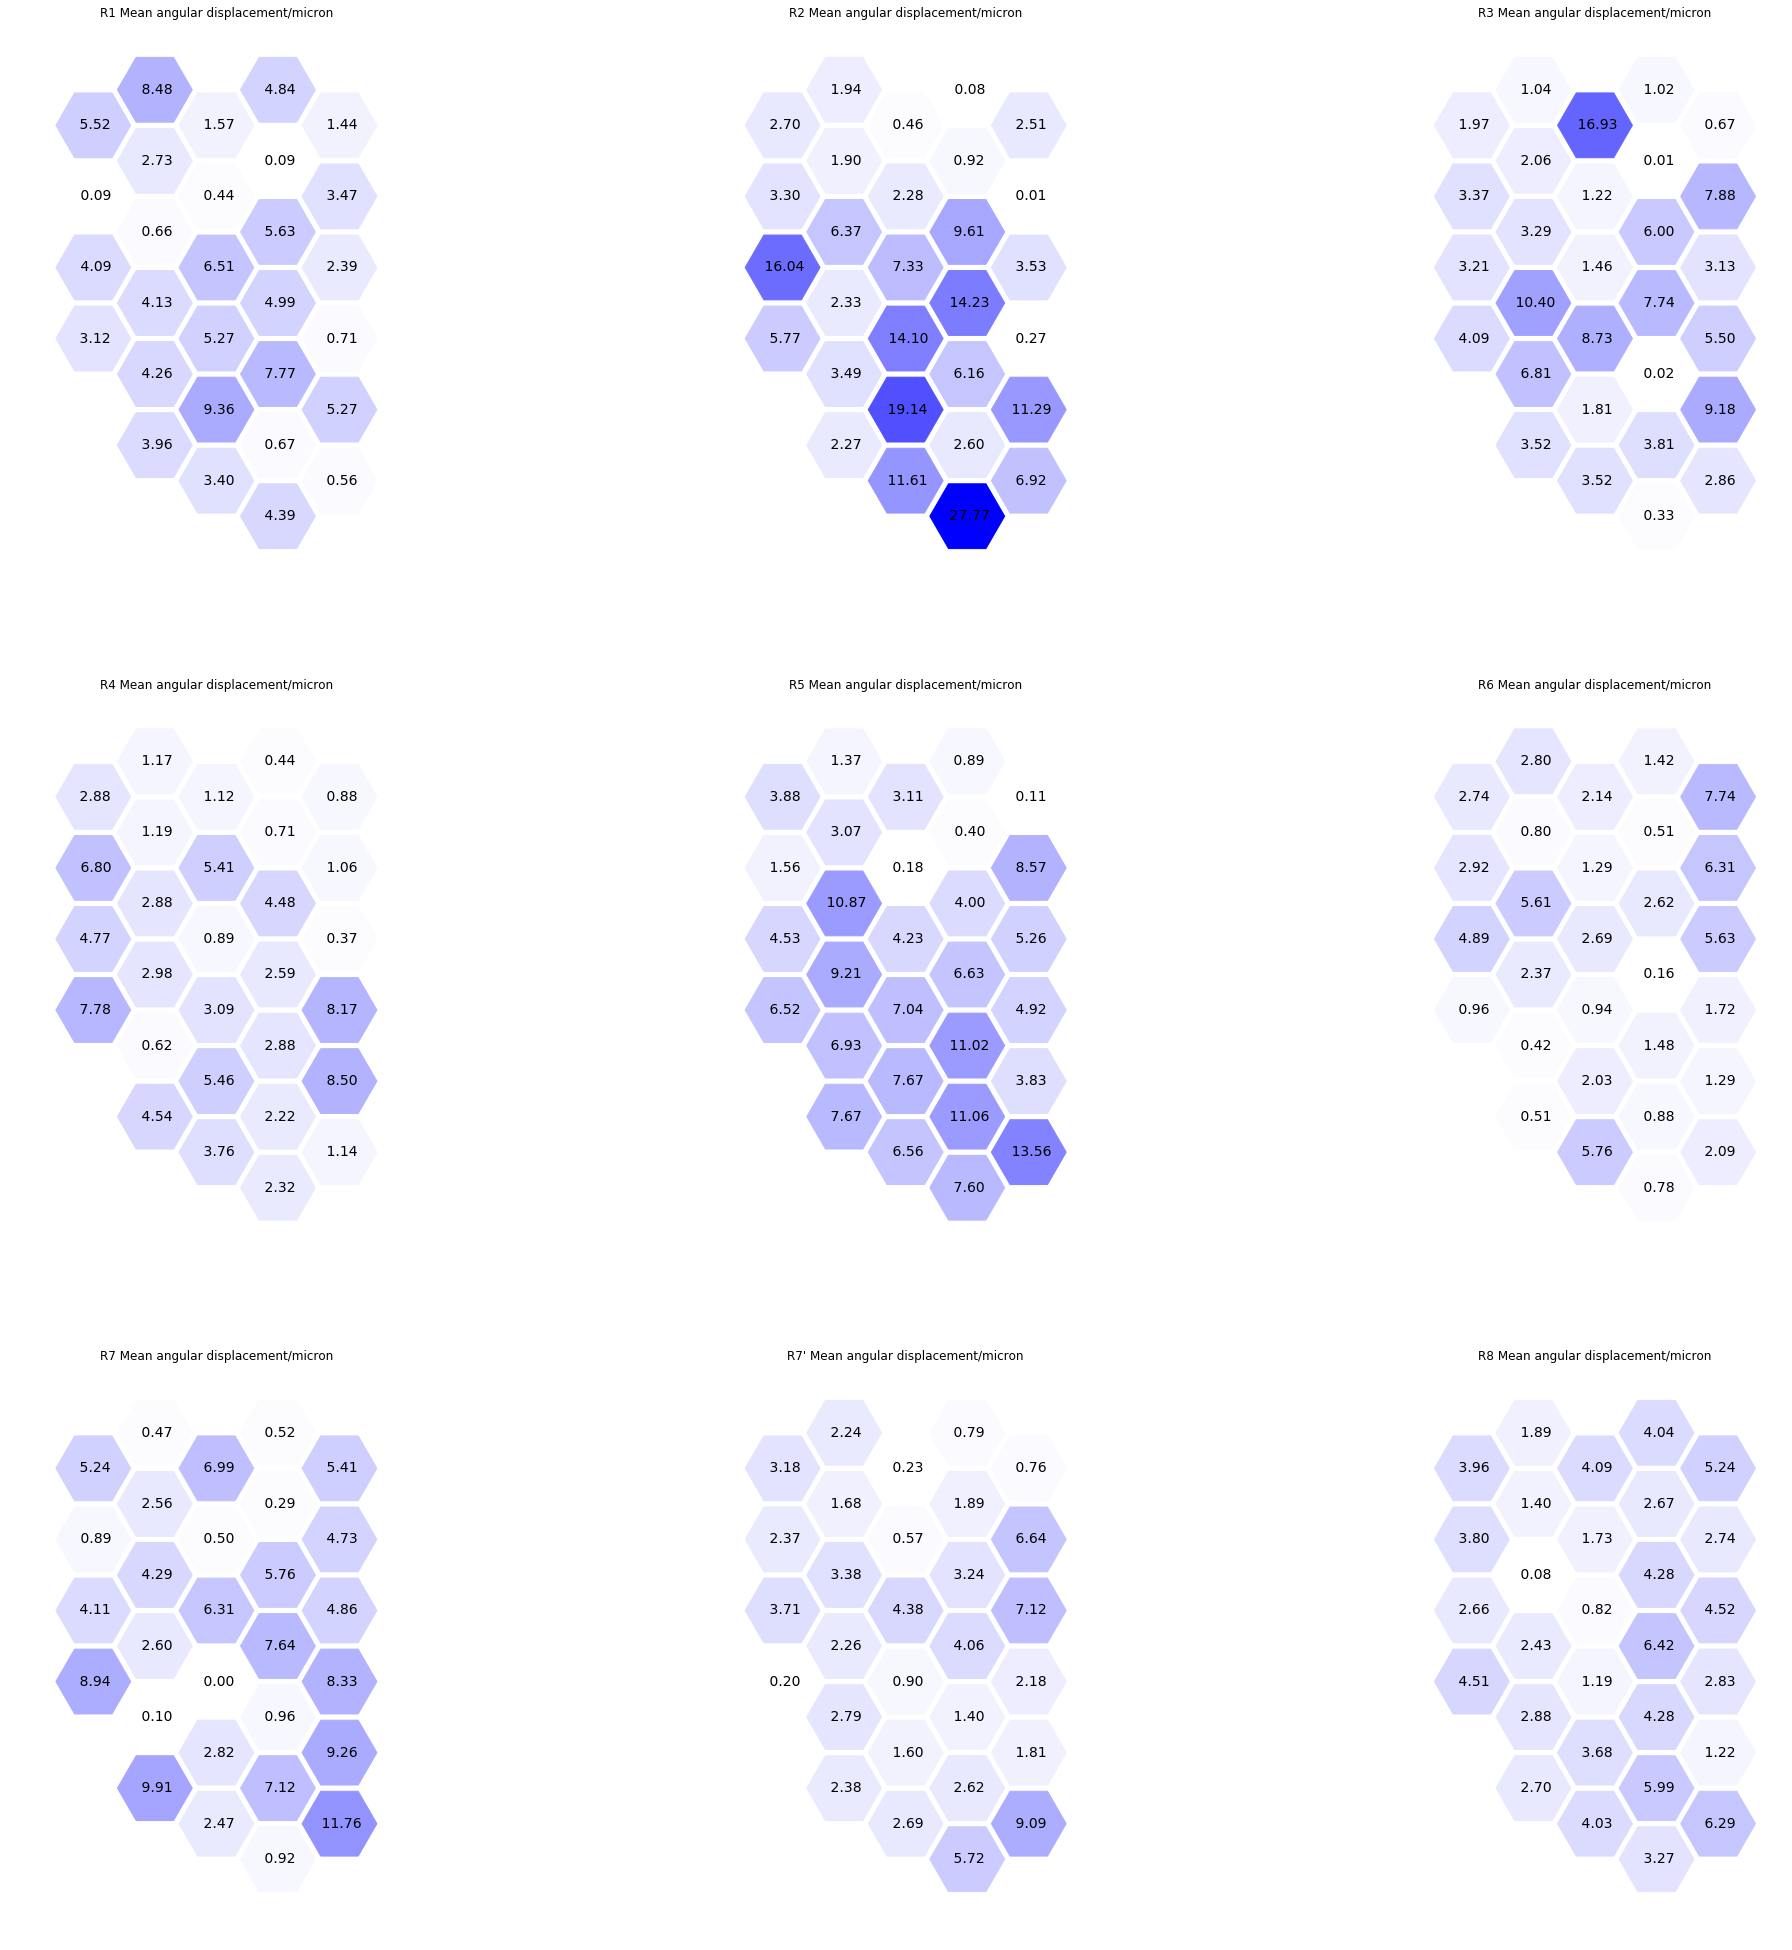

In [16]:
fig, axes = plt.subplots(3, 3, figsize=[35, 35])
# cm = linear_cmap(n_vals=100, max_colour=(1.0, 1.0, 1.0), min_colour='r')
cm = linear_cmap(n_vals=100, max_colour='b')
overall_max = abs(twist_results.loc[:, 'mean_diff']).max().max()

for ax, this_st in zip(axes.flatten(), subtypes):
    node_data = dict.fromkeys(all_om)
    this_max = abs(twist_results.loc[:, ('mean_diff', this_st)]).max()
    for om in all_om:
        x = abs(twist_results.loc[om, ('mean_diff', this_st)])
        node_data[om] = {'label': f"{x: .2f}",
                        'colour': cm(x/overall_max)}
    ax.set_title(f"{this_st} Mean angular displacement/micron")
    hexplot(node_data=node_data, ax=ax)

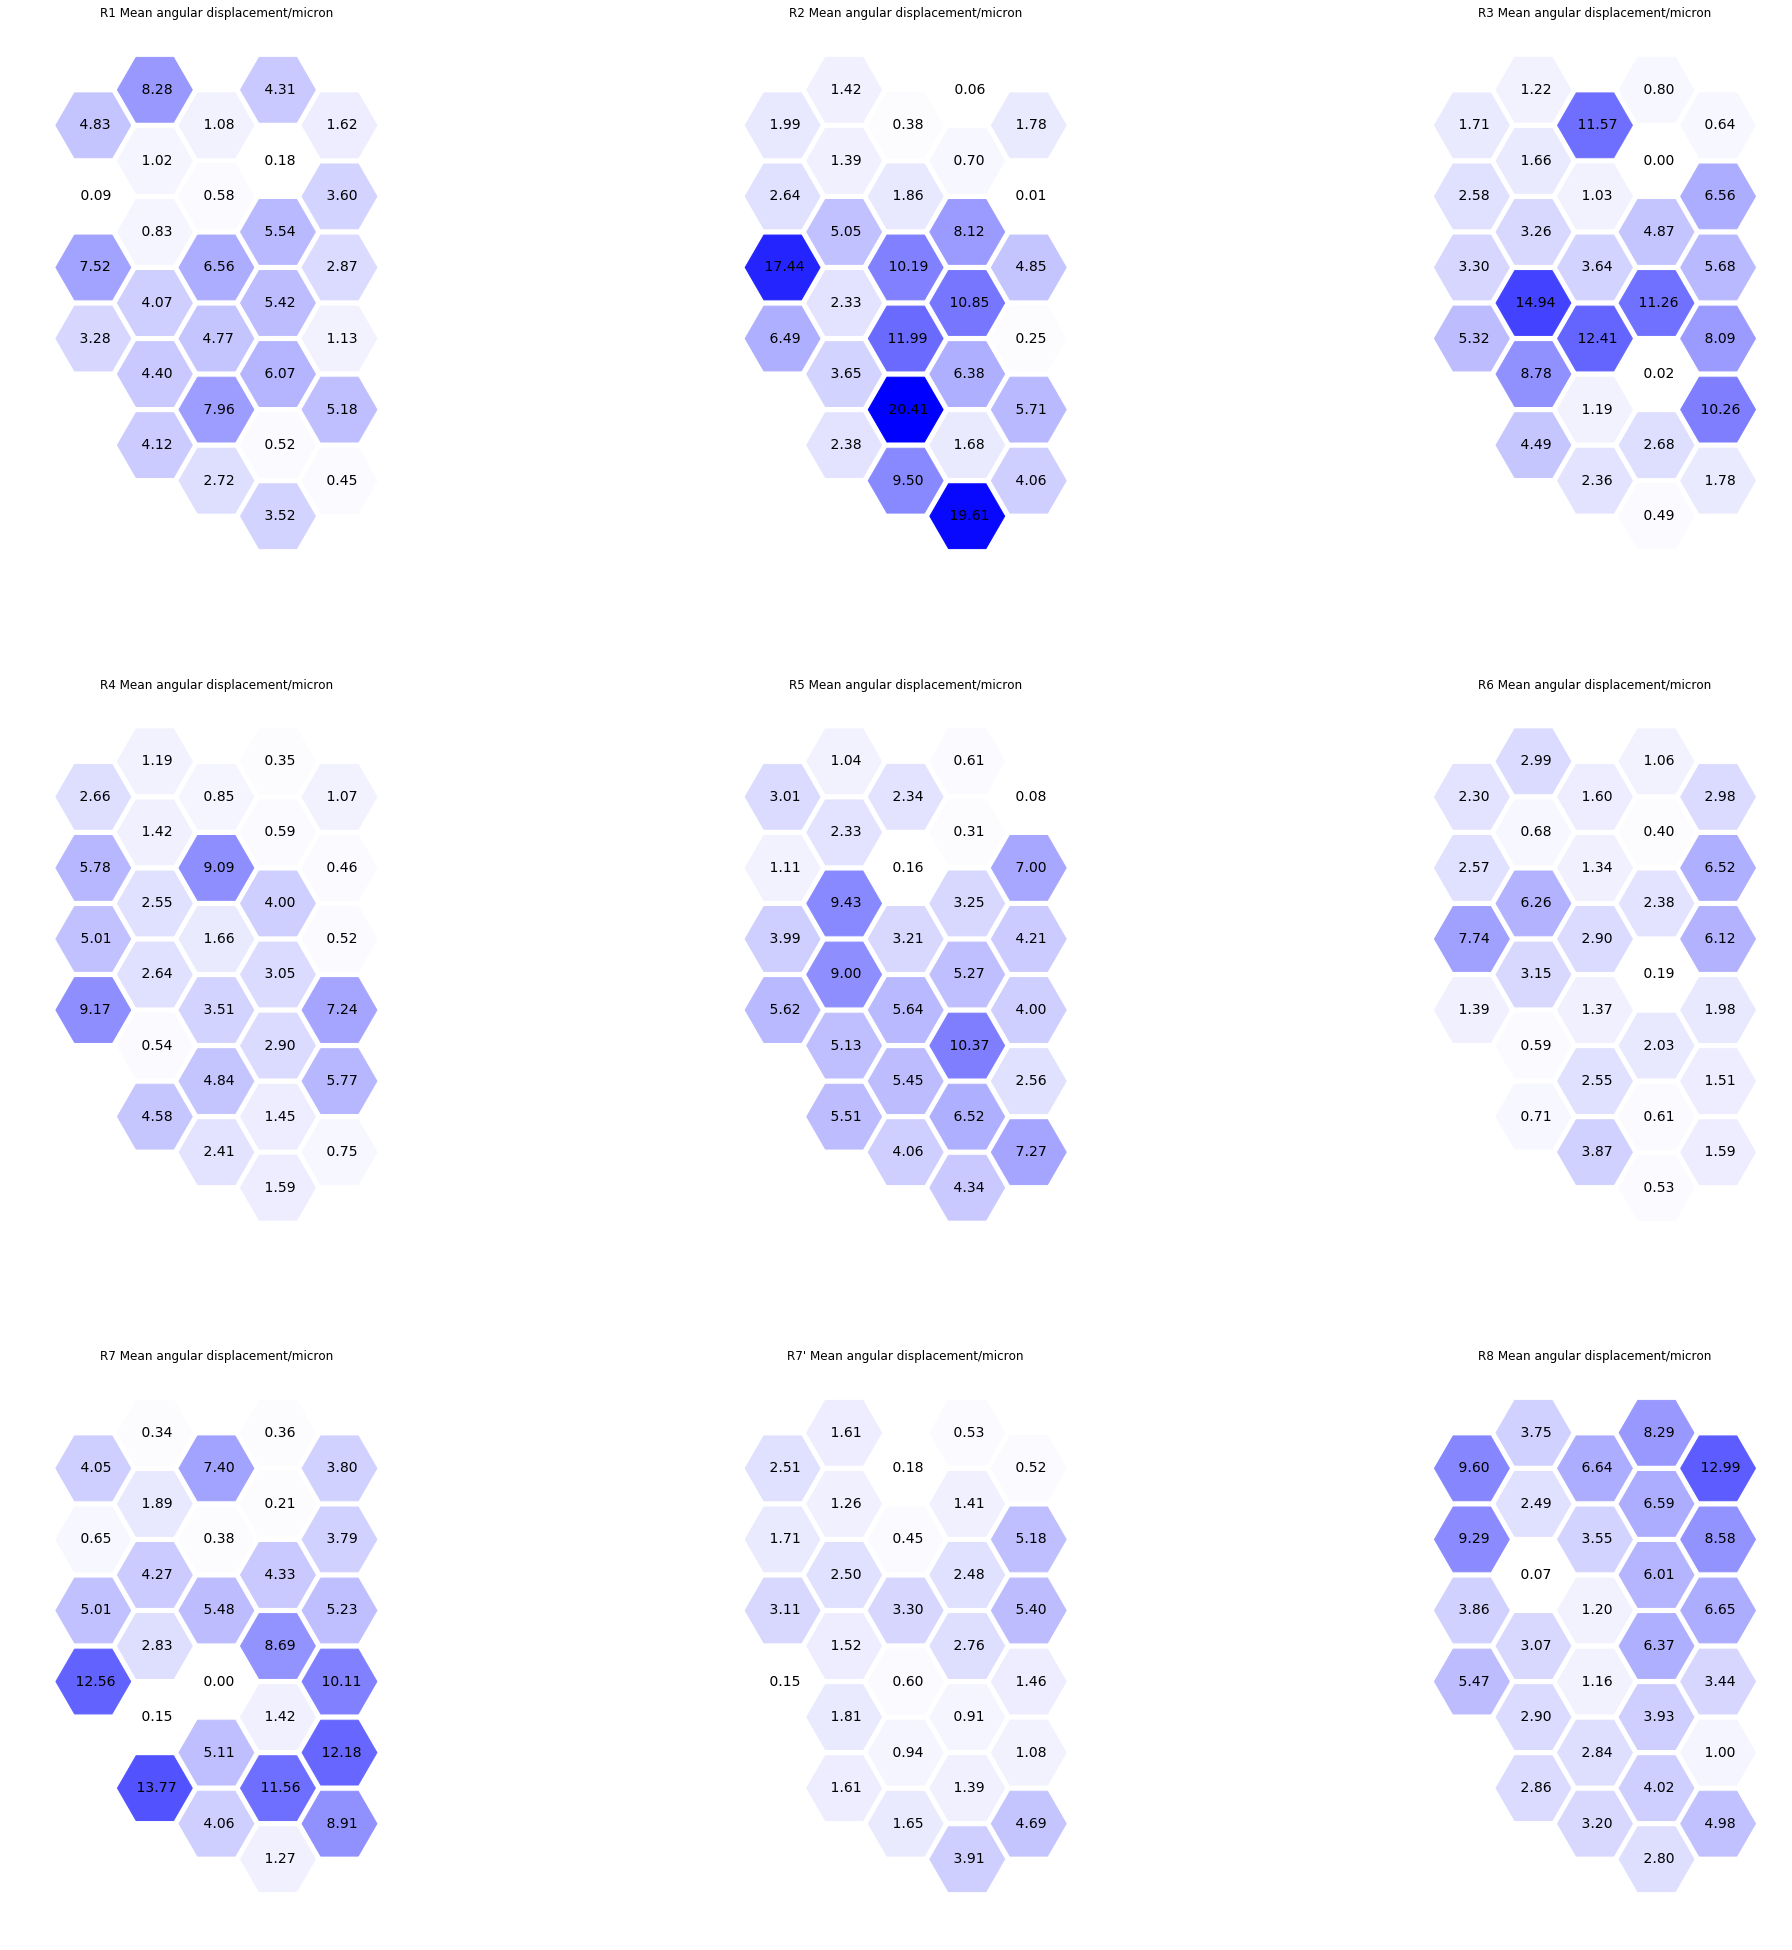

In [17]:
fig, axes = plt.subplots(3, 3, figsize=[35, 35])
# cm = linear_cmap(n_vals=100, max_colour=(1.0, 1.0, 1.0), min_colour='r')
cm = linear_cmap(n_vals=100, max_colour='b')
overall_max = abs(twist_results.loc[:, 'mean_diff_per_micron']).max().max()

for ax, this_st in zip(axes.flatten(), subtypes):
    node_data = dict.fromkeys(all_om)
    this_max = abs(twist_results.loc[:, ('mean_diff_per_micron', this_st)]).max()
    for om in all_om:
        x = abs(twist_results.loc[om, ('mean_diff_per_micron', this_st)])
        node_data[om] = {'label': f"{x: .2f}",
                        'colour': cm(x/overall_max)}
    ax.set_title(f"{this_st} Mean angular displacement/micron")
    hexplot(node_data=node_data, ax=ax)

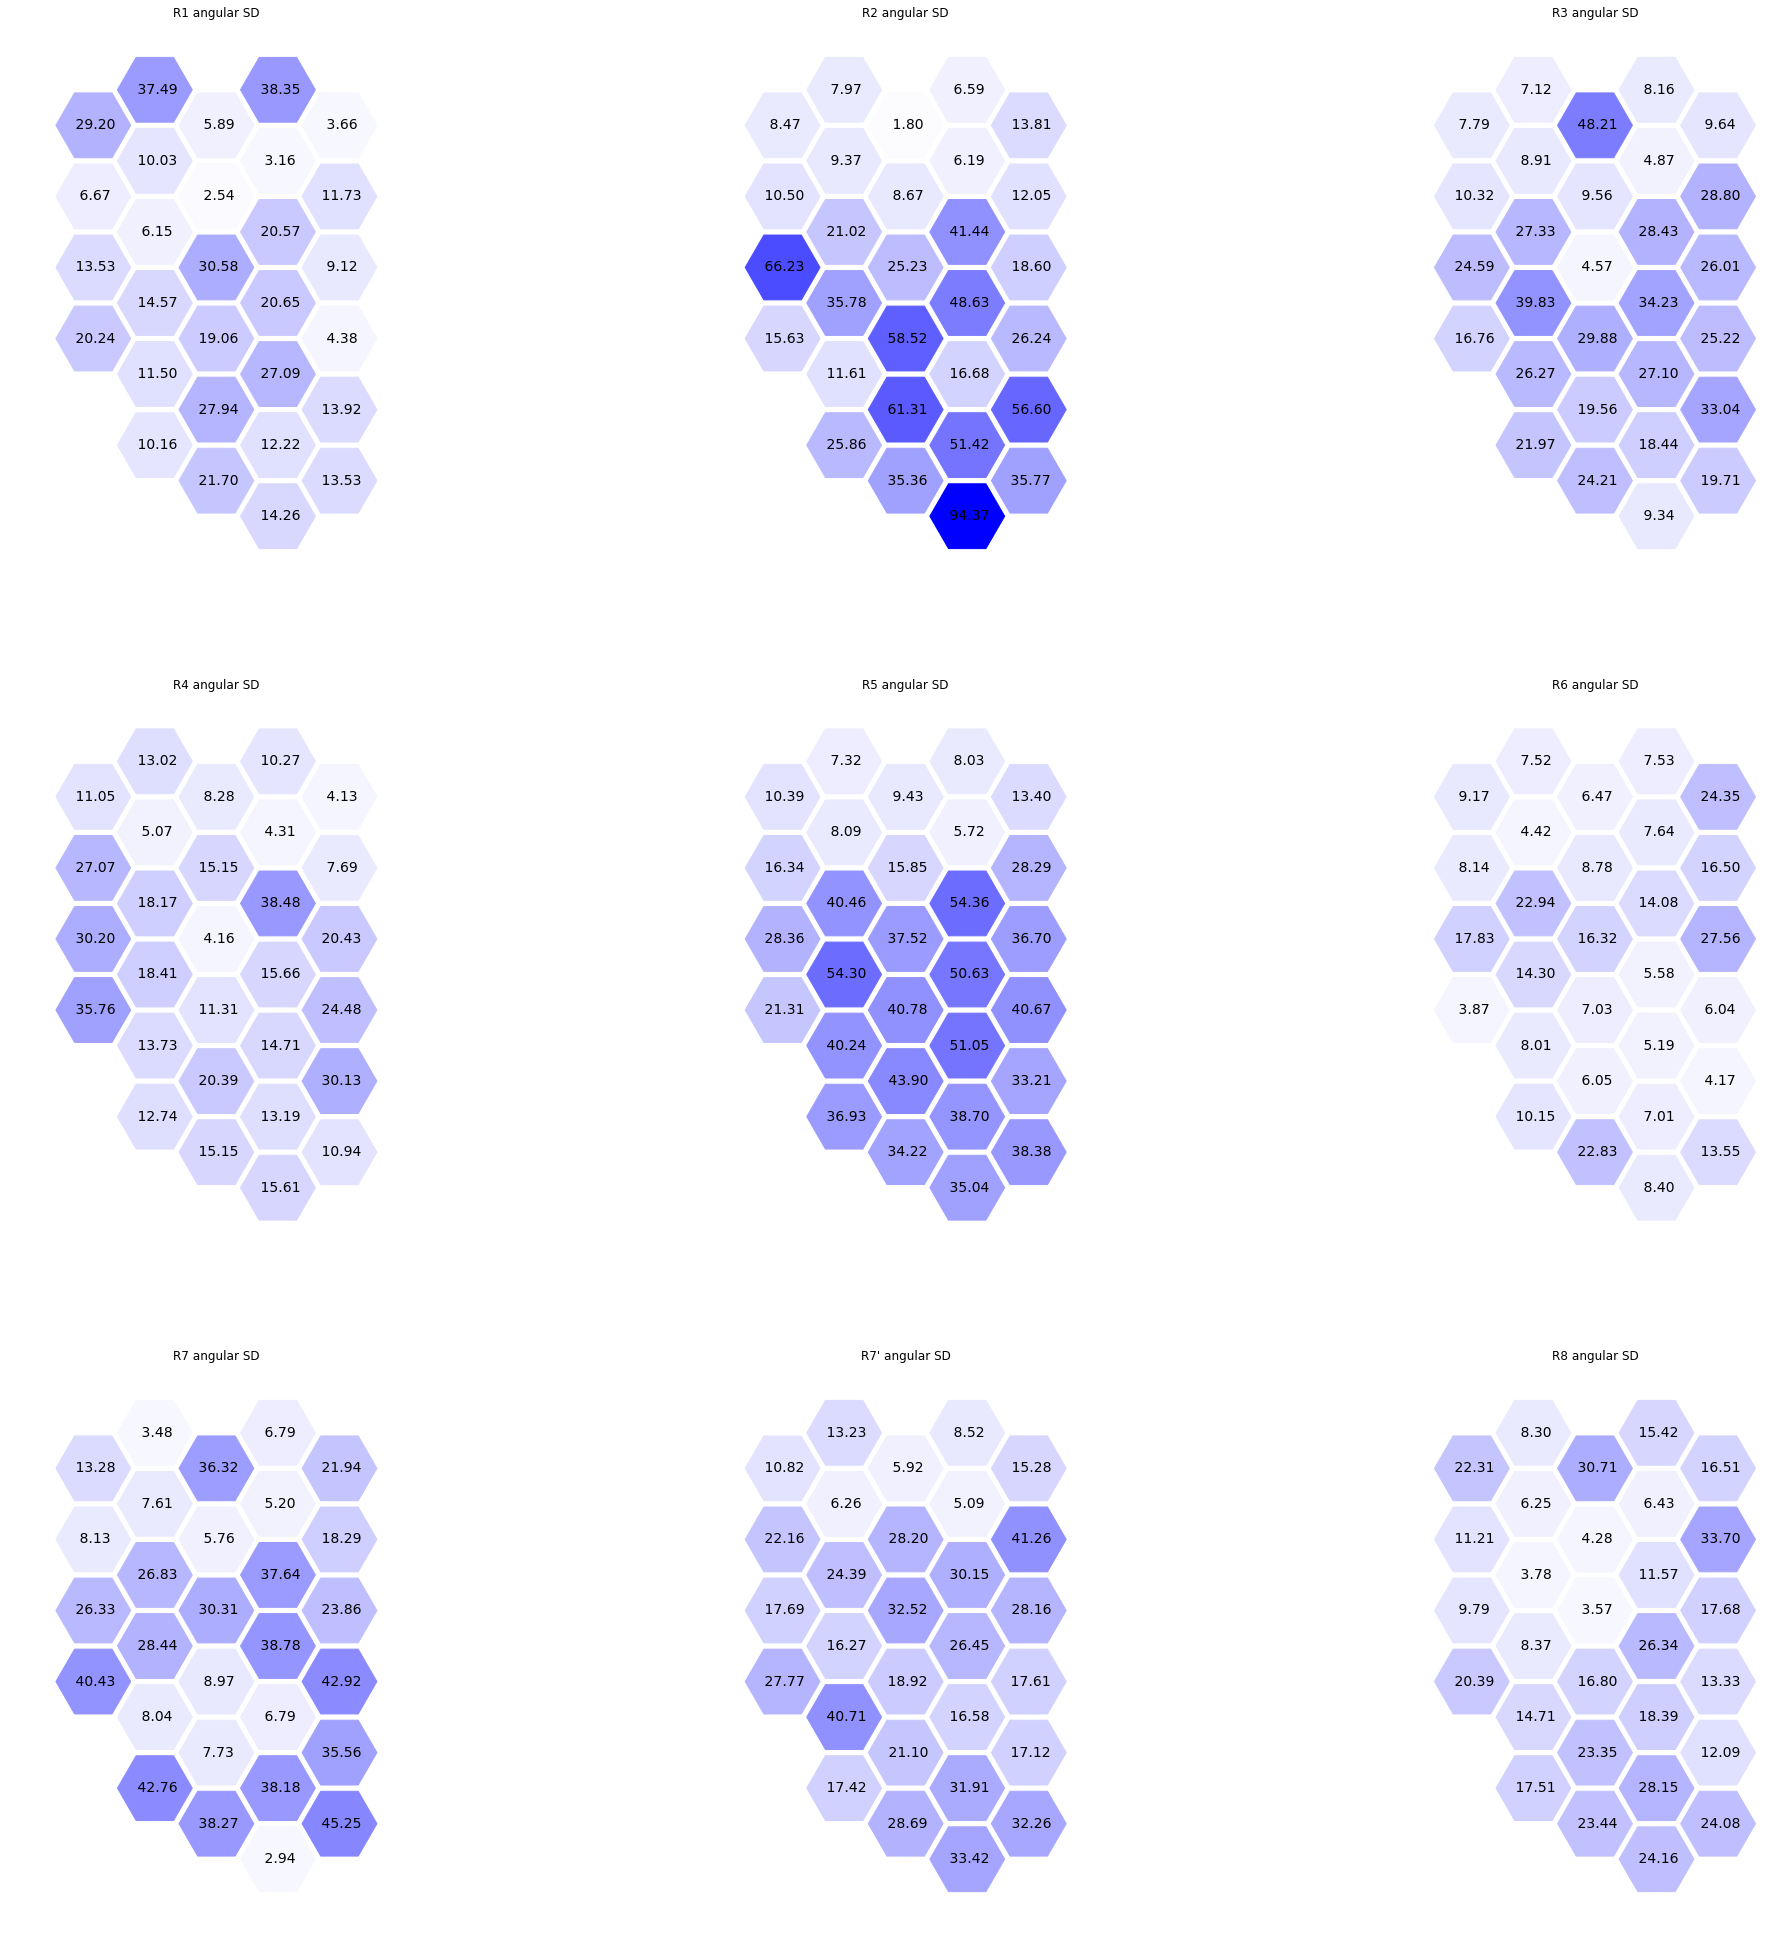

In [18]:
fig, axes = plt.subplots(3, 3, figsize=[35, 35])
# cm = linear_cmap(n_vals=100, max_colour=(1.0, 1.0, 1.0), min_colour='r')
cm = linear_cmap(n_vals=100, max_colour='b')
overall_max = abs(twist_results.loc[:, 'SD_displacement']).max().max()

for ax, this_st in zip(axes.flatten(), subtypes):
    node_data = dict.fromkeys(all_om)
    this_max = abs(twist_results.loc[:, ('SD_displacement', this_st)]).max()
    for om in all_om:
        x = abs(twist_results.loc[om, ('SD_displacement', this_st)])
        node_data[om] = {'label': f"{x: .2f}",
                        'colour': cm(x/overall_max)}
    ax.set_title(f"{this_st} angular SD")
    hexplot(node_data=node_data, ax=ax)

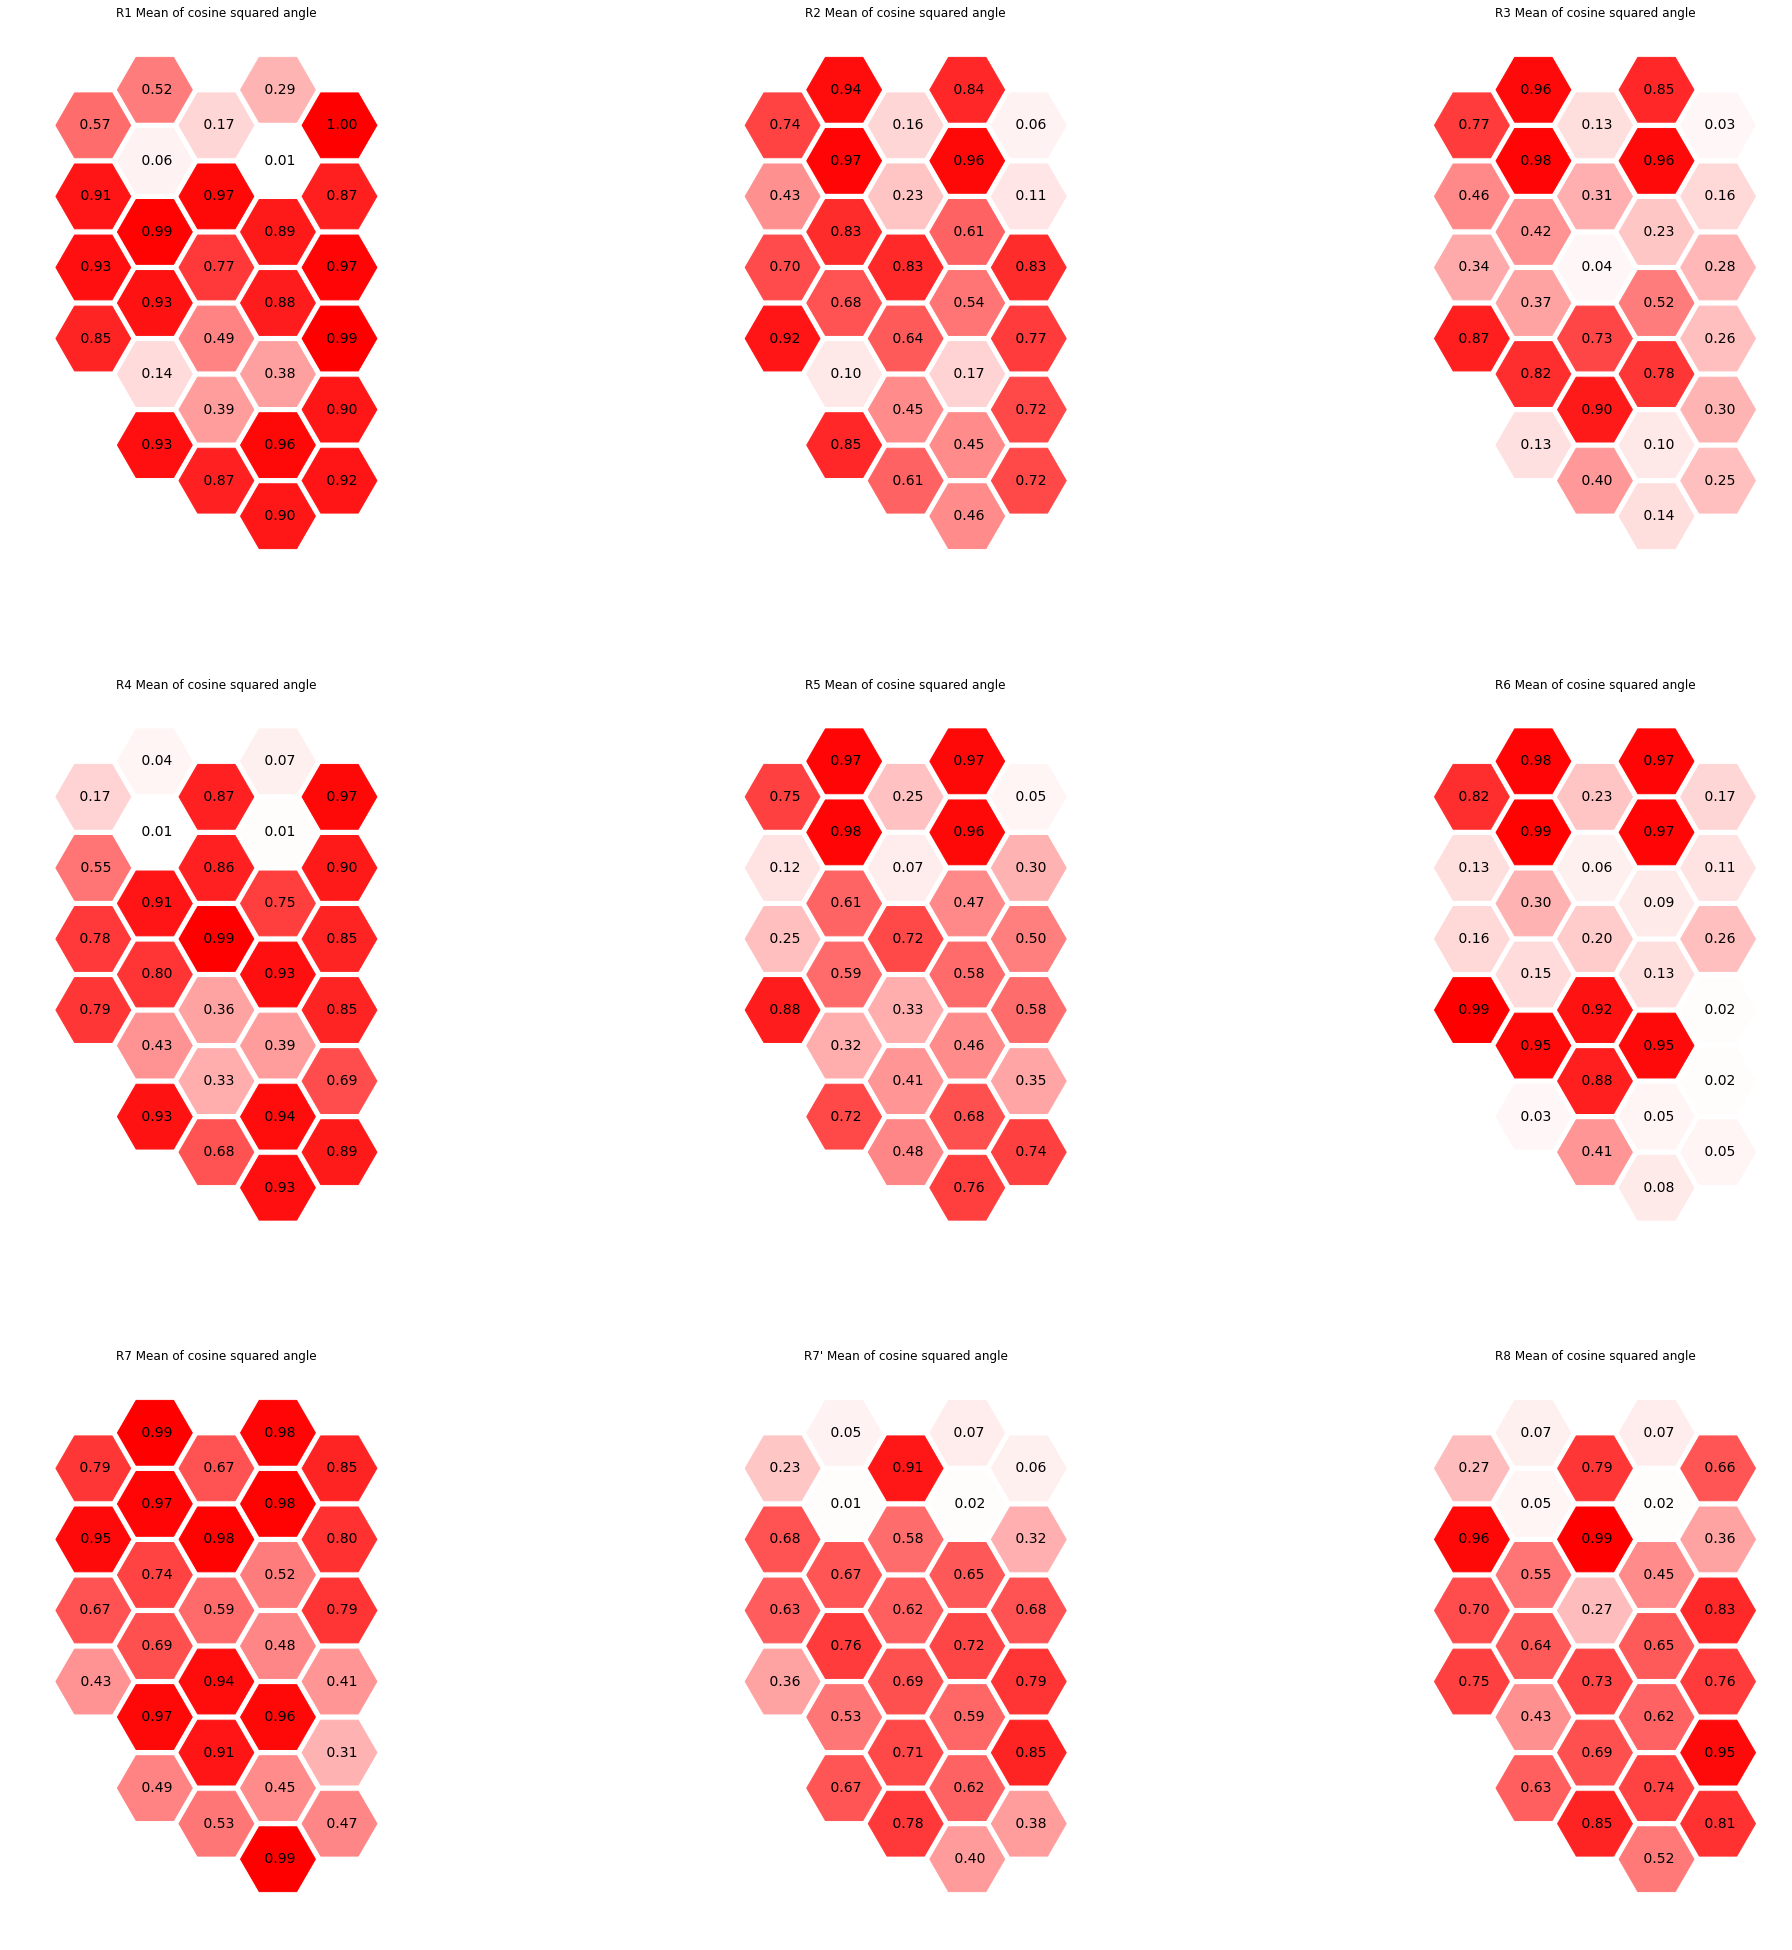

In [19]:


fig, axes = plt.subplots(3, 3, figsize=[35, 35])
# cm = linear_cmap(n_vals=100, max_colour=(1.0, 1.0, 1.0), min_colour='r')
cm = linear_cmap(n_vals=100, max_colour='r')

for ax, this_st in zip(axes.flatten(), subtypes):
    node_data = dict.fromkeys(all_om)
    this_max = twist_results.loc[:, ('mean_cosine_sq', this_st)].max()
    for om in all_om:
        data = twist_results.loc[om, ('mean_cosine_sq', this_st)]
        node_data[om] = {'label': f"{data: .2f}",
                        'colour': cm(data)}
    ax.set_title(f"{this_st} Mean of cosine squared angle")
    hexplot(node_data=node_data, ax=ax)

In [20]:
s, p, = mannwhitneyu(r7_sd[dra_om], r7_sd[ndra_om], alternative='less')
print("###### RESULTS ######")
print(f"Test statistic: {s}, p-value: {p: .6f}")
if p > 0.01:
    print("Fail to reject null")
else:
    print("Reject null: DRA R7 receive more inputs")

NameError: name 'r7_sd' is not defined

In [ ]:
s, p, = mannwhitneyu(r7p_sd[dra_om], r7p_sd[ndra_om], alternative='less')
print("###### RESULTS ######")
print(f"Test statistic: {s}, p-value: {p: .6f}")
if p > 0.01:
    print("Fail to reject null")
else:
    print("Reject null: DRA R7 receive more inputs")